In [35]:
#Import what technolgies you need
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# API key and city list
API_KEY = "3ddbad0c76afd87393241e0456d11b80"  # Replace with your actual key
CITIES = ["Louisville", "Los Angeles", "Chicago", "Houston", "Phoenix"]
DB_NAME = "weather_capstone.db"

In [37]:
def fetch_weather(city: str) -> dict:
    url = "https://api.openweathermap.org/data/2.5/weather"
    params = {"q": city, "appid": API_KEY, "units": "imperial"}
    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return {
            "city": city,
            "temperature": data["main"]["temp"],
            "humidity": data["main"]["humidity"],
            "pressure": data["main"]["pressure"],
            "weather": data["weather"][0]["main"],
            "wind_speed": data["wind"]["speed"]
        }
    else:
        return {}

In [38]:
def categorize_wind(speed: float) -> str:
    if speed < 2:
        return "Calm"
    elif speed < 5:
        return "Breezy"
    else:
        return "Windy"

In [39]:
def clean_weather_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna()
    df["weather"] = df["weather"].str.title()
    df["wind_category"] = df["wind_speed"].apply(categorize_wind)
    return df.reset_index(drop=True)

In [40]:
# Fetch and clean weather data
raw_data = [fetch_weather(city) for city in CITIES]
weather_df = pd.DataFrame([entry for entry in raw_data if entry])
weather_clean = clean_weather_df(weather_df)

# Show cleaned data
weather_clean

,city,temperature,humidity,pressure,weather,wind_speed,wind_category
0,Louisville,71.47,84,1019,Clouds,10.36,Windy
1,Los Angeles,65.57,83,1016,Clear,6.91,Windy
2,Chicago,68.77,74,1024,Haze,6.91,Windy
3,Houston,83.95,80,1017,Clear,8.05,Windy
4,Phoenix,98.15,25,1012,Clouds,3.00,Breezy


In [41]:
# Connect to SQLite
conn = sqlite3.connect(DB_NAME)

# Table 1: Cities
cities_df = pd.DataFrame({"city": CITIES})
cities_df["city_id"] = cities_df.index + 1
cities_df.to_sql("cities", conn, if_exists="replace", index=False)

# Table 2: Weather
weather_clean["city_id"] = weather_clean.index + 1
weather_clean.to_sql("weather", conn, if_exists="replace", index=False)

5

In [42]:
query = """
SELECT w.city, w.temperature, w.humidity, w.pressure, w.weather, w.wind_speed, w.wind_category
FROM weather w
JOIN cities c ON w.city_id = c.city_id
"""
joined_df = pd.read_sql_query(query, conn)
conn.close()

# Show joined data
joined_df

,city,temperature,humidity,pressure,weather,wind_speed,wind_category
0,Louisville,71.47,84,1019,Clouds,10.36,Windy
1,Los Angeles,65.57,83,1016,Clear,6.91,Windy
2,Chicago,68.77,74,1024,Haze,6.91,Windy
3,Houston,83.95,80,1017,Clear,8.05,Windy
4,Phoenix,98.15,25,1012,Clouds,3.00,Breezy


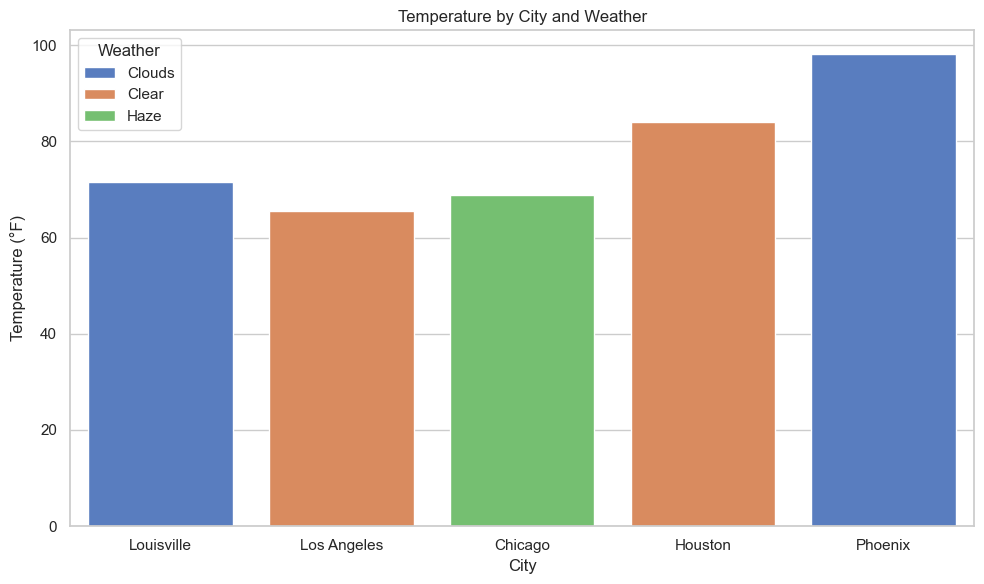

In [43]:
sns.set_theme(style="whitegrid", palette="muted")

plt.figure(figsize=(10, 6))
sns.barplot(data=joined_df, x="city", y="temperature", hue="weather")
plt.title("Temperature by City and Weather")
plt.xlabel("City")
plt.ylabel("Temperature (°F)")
plt.legend(title="Weather")
plt.tight_layout()
plt.show()

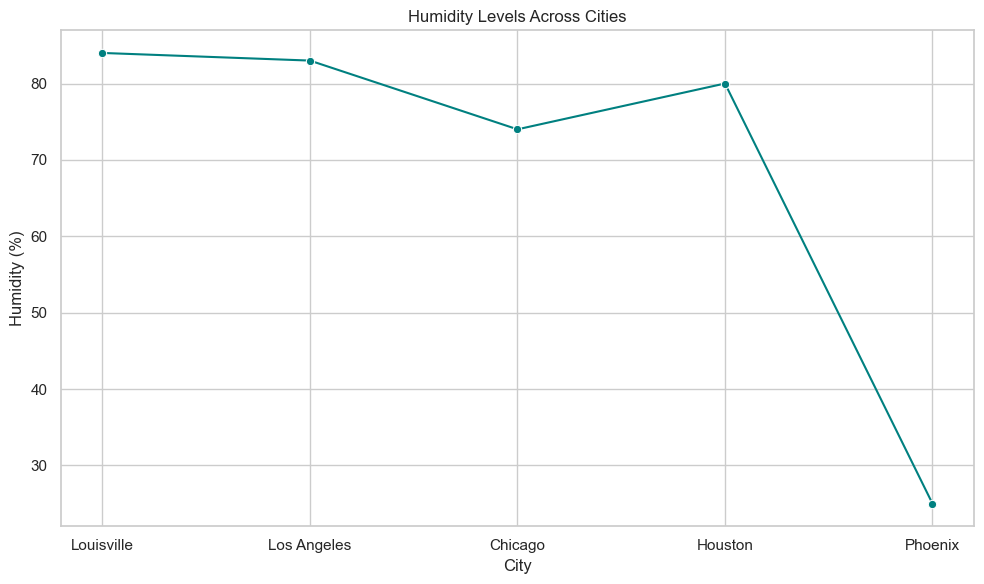

In [44]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=joined_df, x="city", y="humidity", marker="o", color="teal")
plt.title("Humidity Levels Across Cities")
plt.xlabel("City")
plt.ylabel("Humidity (%)")
plt.tight_layout()
plt.show()

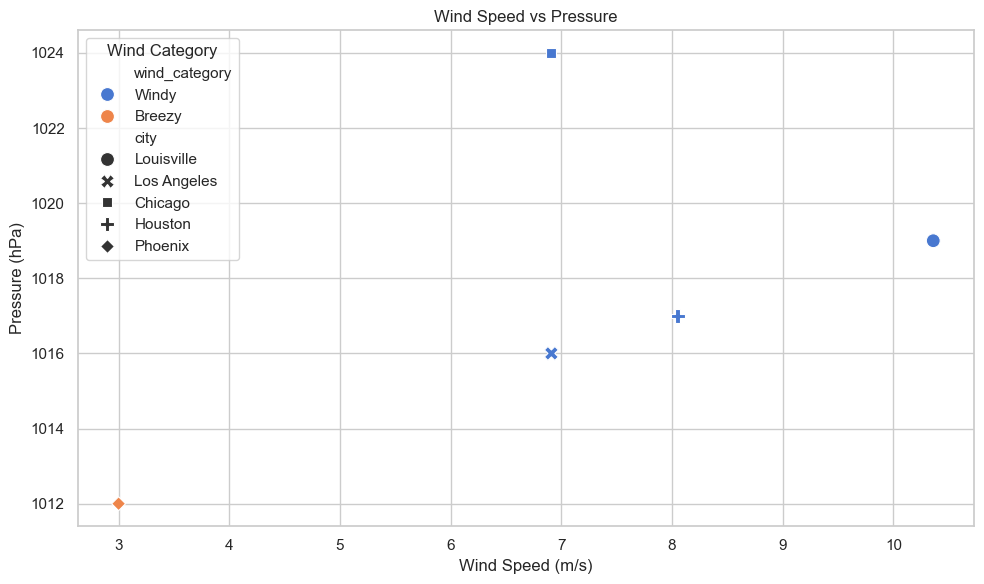

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=joined_df, x="wind_speed", y="pressure", hue="wind_category", style="city", s=100)
plt.title("Wind Speed vs Pressure")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Pressure (hPa)")
plt.legend(title="Wind Category")
plt.tight_layout()
plt.show()